In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms




from sklearn.metrics import mean_squared_error
import numpy as np
import os
import matplotlib.pyplot as plt


import os
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset
import torch

In [2]:
from PIL import Image

In [3]:
def train(name,model, device, train_loader, optimizer,criterion, epoch):
    model.train()
    p =[]
    t =[]

    for batch_idx, (data1,text,label) in enumerate(train_loader):
        data1,text,label= data1.to(device),text.to(device),label.to(device)
        optimizer.zero_grad()
        # #vit model
        # inputs = feature_extractor(images=data1, return_tensors="pt")
        # output = model(**inputs)
        # #
        # resnet model
        if name=='combined':
            output=model(data1,text)
        else:
            output = model(data1)
        #

        loss = criterion(output[:,0], label)
        loss.backward()
        optimizer.step()
        op = output[:,0]
        t.extend(label.detach().cpu().numpy())
        p.extend(op.detach().cpu().numpy())

        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data1), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


    MSE = mean_squared_error(np.array(t),np.array(p),squared=False)
    print(f"MSE:{MSE:.4f}")
    return MSE

In [31]:
mn=22000
mx=585800
def denormalize(val):
    return (val*(mx-mn))+mn

def test(model, device, test_loader,criterion,name):
    model.eval()
    test_loss = 0
    p =[]
    t =[]
    with torch.no_grad():
        for (data1,text,price) in test_loader:
            data1,text,price= data1.to(device),text.to(device),price.to(device)
            
            # #vit model
            # inputs = feature_extractor(images=data1, return_tensors="pt")
            # output = model(**inputs)
            
            # resnet model
            if name=='combined':
                output=model(data1,text)
            else:
                output = model(data1)
            #
            test_loss += denormalize(criterion(output[:,0], price).item()) # sum up batch loss
            op = output[:,0]
            t.extend([denormalize(i) for i in price.detach().cpu().numpy()])
            p.extend([denormalize(i) for i in op.detach().cpu().numpy()])
        #rocauc = RAS(np.array(t),np.array(p))
        print(len(p))
        MSE = mean_squared_error(np.array(t),np.array(p),squared=False)
        A = MSE



    if not os.path.isdir('models'):
        os.mkdir('models')
    print('\nTest set: Average loss: {:.4f}, MSE score: ({:.4f})\n'.format(
        test_loss/len(test_loader.dataset),A))
    global maxv
    if A<maxv:
        torch.save(model.state_dict(),f"models/test_model_{name}.pth.tar")
        print("model saved")
        maxv=A
    return A
    


In [28]:


class customdata1(Dataset):
    PATH='GVSS_Vision_Data/Annotation.xlsx'
    def __init__(self,root,train=True,transforms=None):
        super().__init__()
        self.root = root
        self.transforms = transforms

        image1 = "images/"
        self.image1=image1
        self.image1_folder = sorted([os.path.join(self.root+image1,x) for x in os.listdir(self.root+image1)])
    

    def __len__(self):
        return len(self.image1_folder)
    def read_files(self,filename):
        P = sorted(os.listdir(filename))
        P = [i for i in P if i[-1]=='g']
        return P


    def __getitem__(self, index):

        images_name = self.read_files(self.root+self.image1)
        imgn=images_name[index]
        i=int(imgn.split('_')[-2])
        text=[]
        df=pd.read_excel(self.PATH)
        txt=df.loc[df['Index']==i]
        text.append(txt['n_Area'].to_numpy()[0])
        text.append(txt['Area per room'].to_numpy()[0])
        text.append(txt['No_of_Bedrooms'].to_numpy()[0])
        text.append(txt['No_of_Bathrooms'].to_numpy()[0])
        text.append(txt['Total room'].to_numpy()[0])
        text.append(txt['If1'].to_numpy()[0])
        text.append(txt['If2'].to_numpy()[0])
        price=txt['n_Price'].to_numpy()[0]
        img1 =  cv2.imread(self.root+self.image1+images_name[index])
        img1 = cv2.resize(img1,(img1.shape[0]*2,img1.shape[1]*2))
        img1=np.array(img1)
        
        if self.transforms is not None:
            img1 = self.transforms(img1)
        return (img1,np.array(text).astype(np.float32),np.float32(price))

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(42)

    

cpu


In [38]:
mt = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    # transforms.Scale()/
])

vit=transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

trainset = customdata1(root="Normalized_Data/train/",train=True,transforms=mt)
testset = customdata1(root="Normalized_Data/test/",train=False,transforms=mt)

train_loader = DataLoader(trainset,batch_size=8,shuffle=False,drop_last=True)
test_loader = DataLoader(testset,batch_size=1,shuffle=False,drop_last=False)

In [8]:
def runmodel(num_epochs,name,model,device,train_loader,test_loader,optimizer,criterion_train,criterion_test):
    mse_tr_lst=[]
    mse_te_lst=[]
    mse_tr=0
    mse_te=0
    for epochs in range(num_epochs):
        mse_tr=train(name,model,device,train_loader,optimizer,criterion_train,epochs)
        mse_te=test(model,device,test_loader,criterion_test,name)
        mse_tr_lst.append(mse_tr)
        mse_te_lst.append(mse_te)

    #append mse to a txt file
    with open("history.txt","a") as f:
        f.write(f"{name} {mse_tr_lst} {mse_te_lst} {mse_te} {np.min(np.array(mse_te_lst))}\n")
    #plotting the graph
    plt.plot(mse_tr_lst,label="Train")
    plt.plot(mse_te_lst,label="Test")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.title("MSE vs Epochs")
    # plt.savefig(f"plots/MSE{name}.png")
    plt.show()

In [9]:
global maxv
maxv = 100000000

In [25]:
num_epochs = 10

name="combined"  #name of the model

In [26]:
from network import Archi2,combined

In [39]:
archi_model=Archi2()
text_feature_dim=7
model = combined(archi_model, text_feature_dim)

c:\Users\aekan\anaconda3\envs\Tensorflow\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aekan\anaconda3\envs\Tensorflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
from network import Archi

In [19]:
model=Archi()

c:\Users\aekan\anaconda3\envs\Tensorflow\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aekan\anaconda3\envs\Tensorflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

Train Epoch: 0 [0/405 (0%)]	Loss: 0.008900
Train Epoch: 0 [8/405 (2%)]	Loss: 0.011987
Train Epoch: 0 [16/405 (4%)]	Loss: 0.002199
Train Epoch: 0 [24/405 (6%)]	Loss: 0.060028
Train Epoch: 0 [32/405 (8%)]	Loss: 0.007745
Train Epoch: 0 [40/405 (10%)]	Loss: 0.023160
Train Epoch: 0 [48/405 (12%)]	Loss: 0.014700
Train Epoch: 0 [56/405 (14%)]	Loss: 0.003064
Train Epoch: 0 [64/405 (16%)]	Loss: 0.022523
Train Epoch: 0 [72/405 (18%)]	Loss: 0.018579
Train Epoch: 0 [80/405 (20%)]	Loss: 0.005019
Train Epoch: 0 [88/405 (22%)]	Loss: 0.008397
Train Epoch: 0 [96/405 (24%)]	Loss: 0.006976
Train Epoch: 0 [104/405 (26%)]	Loss: 0.034667
Train Epoch: 0 [112/405 (28%)]	Loss: 0.006851
Train Epoch: 0 [120/405 (30%)]	Loss: 0.000559
Train Epoch: 0 [128/405 (32%)]	Loss: 0.008130
Train Epoch: 0 [136/405 (34%)]	Loss: 0.014275
Train Epoch: 0 [144/405 (36%)]	Loss: 0.011010
Train Epoch: 0 [152/405 (38%)]	Loss: 0.001230
Train Epoch: 0 [160/405 (40%)]	Loss: 0.003296
Train Epoch: 0 [168/405 (42%)]	Loss: 0.007104
Train Ep

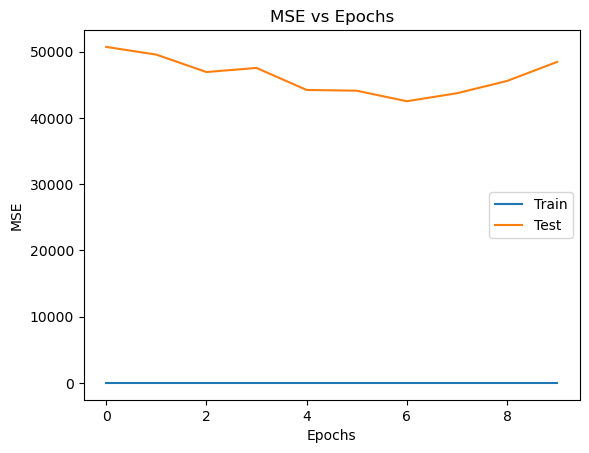

In [41]:

criterion_train = nn.MSELoss().to(device)
criterion_test = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
runmodel(num_epochs,name,model,device,train_loader,test_loader,optimizer,criterion_train,criterion_test)

Train Epoch: 0 [0/405 (0%)]	Loss: 31457632256.000000
Train Epoch: 0 [8/405 (2%)]	Loss: 78940348416.000000
Train Epoch: 0 [16/405 (4%)]	Loss: 4198021376.000000
Train Epoch: 0 [24/405 (6%)]	Loss: 869983977472.000000
Train Epoch: 0 [32/405 (8%)]	Loss: 34250672128.000000
Train Epoch: 0 [40/405 (10%)]	Loss: 258600108032.000000
Train Epoch: 0 [48/405 (12%)]	Loss: 24747100160.000000
Train Epoch: 0 [56/405 (14%)]	Loss: 8315598336.000000
Train Epoch: 0 [64/405 (16%)]	Loss: 214062514176.000000
Train Epoch: 0 [72/405 (18%)]	Loss: 180708376576.000000
Train Epoch: 0 [80/405 (20%)]	Loss: 24430209024.000000
Train Epoch: 0 [88/405 (22%)]	Loss: 58186174464.000000
Train Epoch: 0 [96/405 (24%)]	Loss: 52954148864.000000
Train Epoch: 0 [104/405 (26%)]	Loss: 578016182272.000000
Train Epoch: 0 [112/405 (28%)]	Loss: 39946137600.000000
Train Epoch: 0 [120/405 (30%)]	Loss: 14275172352.000000
Train Epoch: 0 [128/405 (32%)]	Loss: 46735552512.000000
Train Epoch: 0 [136/405 (34%)]	Loss: 127082881024.000000
Train Ep

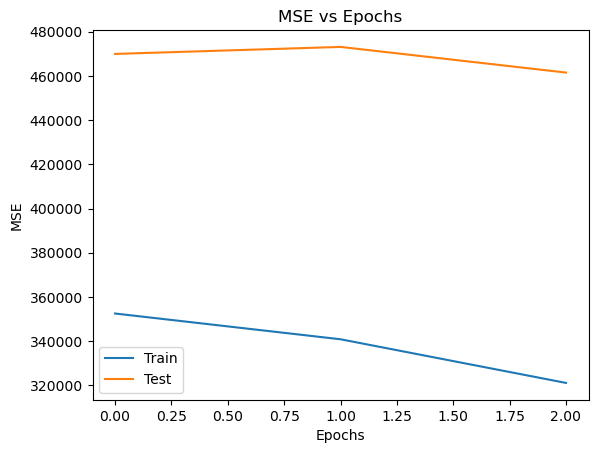

In [23]:
runmodel(15,name,model,device,train_loader,test_loader,optimizer,criterion_train,criterion_test)